In [1]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import re
import ast
import pandas as pd


### Load in scores and outputs from step-beam

In [ ]:
# Load and process the .jsonl file
def load_jsonl_extract_accuracy(jsonl_path):
    data = []

    with open(jsonl_path, "r") as f:
        for line in f:
            entry = json.loads(line)
            question = entry["question"]
            score_list = entry["score"] # (beam_size x beam_width) Boolean values indicating correctness for each question.
            accuracy = sum(score_list) / len(score_list) if score_list else 0.0
            data.append({
                "question": question,
                "score": score_list,
                "accuracy": accuracy
            })

    return pd.DataFrame(data)

In [7]:
def load_dataset(path):
    dataset = []
    with open(path, "r") as f:
        for line in f:
            example = json.loads(line)
            dataset.append(example)
    return pd.DataFrame(dataset)

data_path = "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_n_completions.jsonl" # "your_dataset.jsonl"
df = load_dataset(data_path)
# print(f"Loaded {len(dataset)} examples.")
# print("First problem:", dataset[0]["problem"])

In [8]:
df.head()

,problem,solution,answer,subject,level,unique_id,completions,scores,pred,completion_tokens,agg_scores,pred_weighted@1,pred_maj@1,pred_naive@1,pred_weighted@2,pred_maj@2,pred_naive@2,pred_weighted@4,pred_maj@4,pred_naive@4
0,"Convert the point $(0,3)$ in rectangular coord...",We have that $r = \sqrt{0^2 + 3^2} = 3.$ Also...,"\left( 3, \frac{\pi}{2} \right)",Precalculus,2,test/precalculus/807.json,"[To convert the point $(0,3)$ from rectangular...","[[0.98828125, 0.8671875, 0.99609375, 0.9960937...","To convert rectangular coordinates $(x, y)$ to...","[293, 229, 291, 213]","[0.83984375, 1.0, 0.99609375, 1.0]","\boxed{(3,\frac{3\pi}{2})}","\boxed{(3,\frac{3\pi}{2})}","\boxed{(3,\frac{3\pi}{2})}","\boxed{(3,\frac{\pi}{2})}","\boxed{(3,\frac{3\pi}{2})}","\boxed{(3,\frac{\pi}{2})}","\boxed{(3,\frac{\pi}{2})}","\boxed{(3,\frac{\pi}{2})}","\boxed{(3,\frac{\pi}{2})}"
1,Define\n\[p = \sum_{k = 1}^\infty \frac{1}{k^2...,We count the number of times $\frac{1}{n^3}$ a...,p - q,Intermediate Algebra,5,test/intermediate_algebra/1994.json,"[To solve the problem, we will break it down i...","[[1.0, 0.1689453125, 0.99609375, 0.796875, 0.3...","To solve the problem, we start by expressing t...","[972, 1293, 905, 684]","[0.93359375, 0.8359375, 1.0, 0.0136108398]",\boxed{\frac{\pi^2}{3}},\boxed{\frac{\pi^2}{3}},\boxed{\frac{\pi^2}{3}},\boxed{\frac{\pi^2}{3}},\boxed{\frac{\pi^2}{3}},\boxed{\frac{\pi^2}{3}},\boxed{p-q},\boxed{p-q},\boxed{p-q}
2,"If $f(x) = \frac{3x-2}{x-2}$, what is the valu...",$f(-2)+f(-1)+f(0)=\frac{3(-2)-2}{-2-2}+\frac{3...,\frac{14}{3},Algebra,3,test/algebra/2584.json,"[To solve the problem, we need to evaluate the...","[[0.99609375, 0.99609375, 1.0, 1.0, 1.0, 1.0, ...","To solve the problem, we need to evaluate the ...","[423, 431, 478, 556]","[1.0, 1.0, 1.0, 1.0]",\boxed{\frac{14}{3}},\boxed{\frac{14}{3}},\boxed{\frac{14}{3}},\boxed{\frac{14}{3}},\boxed{\frac{14}{3}},\boxed{\frac{14}{3}},\boxed{\frac{14}{3}},\boxed{\frac{14}{3}},\boxed{\frac{14}{3}}
3,How many positive whole-number divisors does 1...,First prime factorize $196=2^2\cdot7^2$. The ...,9,Number Theory,3,test/number_theory/572.json,[To determine the number of positive whole-num...,"[[1.0, 0.99609375, 0.99609375, 0.9921875, 0.99...",To determine the number of positive whole-numb...,"[511, 258, 434, 263]","[1.0, 1.0, 1.0, 0.0825195312]",\boxed{9},\boxed{9},\boxed{9},\boxed{9},\boxed{9},\boxed{9},\boxed{9},\boxed{9},\boxed{9}
4,The results of a cross-country team's training...,Evelyn covered more distance in less time than...,\text{Evelyn},Algebra,2,test/algebra/1349.json,[To determine which student has the greatest a...,"[[0.99609375, 0.0947265625, 0.97265625, 0.1552...",To find the student with the greatest average ...,"[313, 369, 344, 101]","[0.93359375, 0.82421875, 0.9453125, 0.9296875]",\boxed{Evelyn},\boxed{Evelyn},\boxed{Evelyn},\boxed{Evelyn},\boxed{Evelyn},\boxed{Evelyn},\boxed{Evelyn},\boxed{Evelyn},\boxed{Evelyn}


In [27]:
import re

def normalize_latex(expr):
    # change to a string.
    expr = str(expr)
    # Remove \boxed{...} wrapper if present
    expr = re.sub(r"\\boxed{(.*)}", r"\1", expr)
    # Remove \left and \right
    expr = expr.replace("\\left", "").replace("\\right", "")
    # Remove whitespace
    expr = re.sub(r"\s+", "", expr)
    return expr

def approx_match(ans1, ans2):
    return normalize_latex(ans1) == normalize_latex(ans2)

In [ ]:
df_dict = {
    "df_n2": df_n2,
    "df_n4": df_n4,
    "df_n8": df_n8,
    "df_n16": df_n16,
    "df_n32": df_n32
}

pattern = re.compile(r'(\d+)x(\d+)_(\d+)')

for name, df in df_dict.items():
    match = pattern.search(name)
    if match:
        beam_size, beam_width, chunk_size = map(int, match.groups())
        df['beam_size'] = beam_size
        df['beam_width'] = beam_width
        df['chunk_size'] = chunk_size
    # Returns true if the majority of scores are True, else false.
    df["majority_true"] = df["score"].apply(lambda x: sum(x) > len(x) / 2)
    df["majority_true"] = df["majority_true"].astype(int)
    # rename the index to sb_idx
    df["sb_idx"] = df.index.tolist()

In [6]:
df_2x2_64.head()

,question,score,accuracy,beam_size,beam_width,chunk_size,majority_true,sb_idx
0,"Two trains of equal length, running with the s...","[True, True, True, True]",1.0,2,2,64,1,0
1,"On four cards were four different digits, one ...","[False, False, False, False]",0.0,2,2,64,0,1
2,Victor initially had 35.5 books. During the bo...,"[True, True, True, True]",1.0,2,2,64,1,2
3,Define $g$ by $g(x)=5x-4$. If $g(x)=f^{-1}(x)-...,"[True, True, True, True]",1.0,2,2,64,1,3
4,Cara is sitting with her seven friends in a li...,"[True, True, True, True]",1.0,2,2,64,1,4


In [ ]:
df_list = [df_2x2_64, df_4x4_128, df_8x2_256, df_32x2_128, df_8x4_256]
df_all = pd.concat(df_list, ignore_index=True)

In [8]:
df_all.head()

,question,score,accuracy,beam_size,beam_width,chunk_size,majority_true,sb_idx
0,"Two trains of equal length, running with the s...","[True, True, True, True]",1.0,2,2,64,1,0
1,"On four cards were four different digits, one ...","[False, False, False, False]",0.0,2,2,64,0,1
2,Victor initially had 35.5 books. During the bo...,"[True, True, True, True]",1.0,2,2,64,1,2
3,Define $g$ by $g(x)=5x-4$. If $g(x)=f^{-1}(x)-...,"[True, True, True, True]",1.0,2,2,64,1,3
4,Cara is sitting with her seven friends in a li...,"[True, True, True, True]",1.0,2,2,64,1,4


In [9]:
df_all['accuracy'].describe(), df_all['majority_true'].describe(), np.mean(df_all['majority_true'])

(count    2500.000000
 mean        0.517262
 std         0.439175
 min         0.000000
 25%         0.000000
 50%         0.562500
 75%         1.000000
 max         1.000000
 Name: accuracy, dtype: float64,
 count    2500.000000
 mean        0.510400
 std         0.499992
 min         0.000000
 25%         0.000000
 50%         1.000000
 75%         1.000000
 max         1.000000
 Name: majority_true, dtype: float64,
 0.5104)

In [ ]:
output_jsonl_2x2_64 = "/dccstor/gma2/jhjenny9/step-beam/outputs/test/granite-3.3-8b-it_PRM_Qwen2.5-Math-PRM-7B/stepBeam_1x2x2_mt64_steps14_s12345_6cd5ab1024e74c1348d818ec2b319c89/beam_output.jsonl"
output_jsonl_4x4_128 = "/dccstor/gma2/jhjenny9/step-beam/outputs/test/granite-3.3-8b-it_PRM_Qwen2.5-Math-PRM-7B/stepBeam_1x4x4_mt128_steps14_s12345_341af0b6d00baf288b23ebff0b438eed/beam_output.jsonl"
output_jsonl_8x2_256 = "/dccstor/gma2/jhjenny9/step-beam/outputs/test/granite-3.3-8b-it_PRM_Qwen2.5-Math-PRM-7B/stepBeam_1x8x2_mt256_steps14_s12345_2c76dca5fdee7c82b22ef590f38f6a9e/beam_output.jsonl"
output_jsonl_32x2_128 = "/dccstor/gma2/jhjenny9/step-beam/outputs/test/granite-3.3-8b-it_PRM_Qwen2.5-Math-PRM-7B/stepBeam_1x32x2_mt128_steps14_s12345_345bc0d098f88a301c7717d185b4ec54/beam_output.jsonl"
output_jsonl_8x4_256 = "/dccstor/gma2/jhjenny9/step-beam/outputs/test/granite-3.3-8b-it_PRM_Qwen2.5-Math-PRM-7B/stepBeam_1x8x4_mt256_steps14_s12345_c95f553851233a209bc35cdacb40300f/beam_output.jsonl"

# list of paths
jsonl_paths = [
    output_jsonl_2x2_64,
    output_jsonl_4x4_128,
    output_jsonl_8x2_256,
    output_jsonl_32x2_128,
    output_jsonl_8x4_256
]

# regex to extract beam_size, beam_width, chunk_size
pattern = re.compile(r'stepBeam_1x(\d+)x(\d+)_mt(\d+)')

data = []
for pth in jsonl_paths:
    match = pattern.search(pth)
    if match:
        beam_size, beam_width, chunk_size = map(int, match.groups())
        print(f"beam_size: {beam_size}, beam_width: {beam_width}, chunk_size: {chunk_size}")
    else:
        raise ValueError(f"Path {pth} does not match expected pattern")



    with open(pth, "r") as f:
        for line in f:
            entry = json.loads(line)
            sb_idx = entry['sb_idx']
            sb_generated_token_count = entry['sb_generated_token_count']
            average_step = entry['average_step']

            avg_cot_token_count = sb_generated_token_count / (beam_size * beam_width)

            data.append({
                "sb_idx": sb_idx,
                "beam_size": beam_size,
                "beam_width": beam_width,
                "chunk_size": chunk_size,
                "sb_generated_token_count": sb_generated_token_count,
                "avg_cot_token_count": avg_cot_token_count,
                "average_step": average_step,
            })
df_outputs = pd.DataFrame(data)

beam_size: 2, beam_width: 2, chunk_size: 64
beam_size: 4, beam_width: 4, chunk_size: 128
beam_size: 8, beam_width: 2, chunk_size: 256
beam_size: 32, beam_width: 2, chunk_size: 128
beam_size: 8, beam_width: 4, chunk_size: 256


In [14]:
df_outputs.shape

(2500, 7)

In [15]:
predictor_df = df_all.merge(df_outputs, on=["sb_idx", "beam_size", "beam_width", "chunk_size"], how="inner")
predictor_df.shape

(2500, 11)

In [ ]:
predictor_df["question_length"] = predictor_df["question"].str.len()
predictor_df["50%_beam_length"] = predictor_df["average_step"].apply(lambda x: x[0])
predictor_df["average_step_final"] = predictor_df["average_step"].apply(lambda x: x[1])

In [158]:
col = predictor_df.pop("majority_true")
predictor_df["majority_true"] = col

In [ ]:
# "predictor_df.csv", this is for the 5 configurations above. 2500 rows, 13 columns.
# predictor_df.to_csv("predictor_df.csv", index=False)
predictor_df = pd.read_csv("data/predictor_df.csv")

### Prepare Features for Difficulty Probe.

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from transformers import BertTokenizer, BertModel

/dccstor/gma2/jhjenny9/envs/model_serve/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

CUDA available: False
CUDA device name: No GPU


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
local_model_path = "/u/jhjenny9/.cache/huggingface/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594"
tokenizer = BertTokenizer.from_pretrained(local_model_path)
model = BertModel.from_pretrained(local_model_path).to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [23]:
device = model.device  # Set device to match model
device

device(type='cpu')

In [24]:
def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # CLS token is at position 0
    return cls_embedding.squeeze().numpy()

In [ ]:
# Create train/test split based on 'sb_idx' (query identifier)
from sklearn.model_selection import train_test_split

unique_sb_idx = predictor_df['sb_idx'].unique()

# Split sb_idx into train/test
sb_idx_train, sb_idx_test = train_test_split(
    unique_sb_idx,
    test_size=0.2,
    random_state=6
)

# Divide queries (represented by sb_idx) into train and test sets
df_train = predictor_df[predictor_df['sb_idx'].isin(sb_idx_train)].reset_index(drop=True)
df_test = predictor_df[predictor_df['sb_idx'].isin(sb_idx_test)].reset_index(drop=True)

In [68]:
# (Training Data) Extract features: CLS + decoding parameters
cls_features = []
param_features = []
for _, row in df_train.iterrows():
    cls_vec = get_cls_embedding(row["question"])
    beam_size = row["beam_size"]
    beam_width = row["beam_width"]
    chunk_size = row["chunk_size"]
    #fifty_perc_beam_length = row["50%_beam_length"]
    question_length = row["question_length"]
    num_samples = beam_size * beam_width
    
    # num_trees, num_samples, max_tokens
    features = np.concatenate([cls_vec, [beam_size, beam_width, chunk_size, num_samples, question_length]]) 
    cls_features.append(features)

In [69]:
X_train = np.array(cls_features)
y_train = df_train["majority_true"].values.astype(int)

In [70]:
# (Testing Data) Extract features: CLS + decoding parameters
cls_features = []
param_features = []
for _, row in df_test.iterrows():
    cls_vec = get_cls_embedding(row["question"])
    beam_size = row["beam_size"]
    beam_width = row["beam_width"]
    chunk_size = row["chunk_size"]
    #fifty_perc_beam_length = row["50%_beam_length"]
    question_length = row["question_length"]
    num_samples = beam_size * beam_width
    
    # num_trees, num_samples, max_tokens
    features = np.concatenate([cls_vec, [beam_size, beam_width, chunk_size, num_samples, question_length]]) #
    cls_features.append(features)

In [71]:
X_test = np.array(cls_features)
y_test = df_test["majority_true"].values.astype(int)

### Train MLP.

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

In [75]:
# X_array = np.array(X)
# y_array = np.array(y)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test) 

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.2, random_state=6)

In [76]:
# 2-layer MLP Binary Classifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', max_iter=500, random_state=42)
mlp_clf.fit(X_train, y_train)
y_pred = mlp_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

In [77]:
y_proba = mlp_clf.predict_proba(X_test)[:, 1]

In [78]:
y_proba.shape

(500,)

In [83]:
df_test['predicted_prob'] = y_proba

In [84]:
df_test.head(5)

,question,score,accuracy,beam_size,beam_width,chunk_size,sb_idx,sb_generated_token_count,avg_cot_token_count,average_step,question_length,50%_beam_length,average_step_final,majority_true,predicted_prob
0,Victor initially had 35.5 books. During the bo...,"[True, True, True, True]",1.0,2,2,64,2,1062,265.50,"[5, 5]",290,5,5,1,0.598889
1,\( f(x) \) is an increasing function defined o...,"[False, False, False, False]",0.0,2,2,64,10,2048,512.00,"[2, 14]",265,2,14,0,0.000345
2,The number $s$ can be expressed as a four-plac...,"[False, False, False, False]",0.0,2,2,64,12,3390,847.50,"[14, 14]",342,14,14,0,0.000002
3,"Given the set \( X = \{1, 2, \cdots, 100\} \),...","[True, True, True, True]",1.0,2,2,64,13,3094,773.50,"[12, 13]",325,12,13,1,0.000003
4,James joins a football team and becomes the st...,"[True, True, True, True]",1.0,2,2,64,16,1395,348.75,"[6, 6]",346,6,6,1,0.977490


In [85]:
df_test['predicted_prob']

0      0.598889
1      0.000345
2      0.000002
3      0.000003
4      0.977490
         ...   
495    0.084650
496    0.018211
497    0.968794
498    0.016176
499    0.000240
Name: predicted_prob, Length: 500, dtype: float64

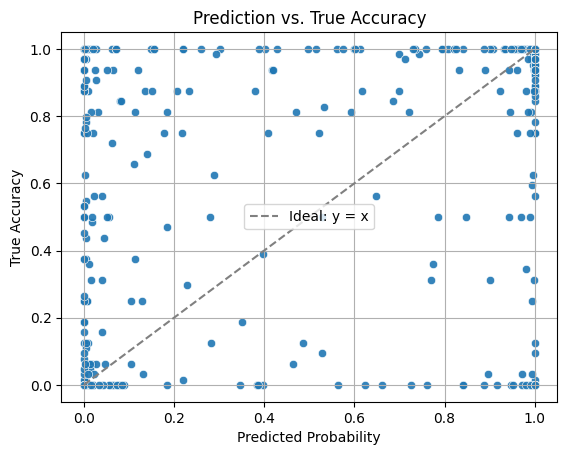

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x='predicted_prob', y='accuracy', data=df_test, alpha=0.9)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Ideal: y = x')
plt.xlabel('Predicted Probability')
plt.ylabel('True Accuracy')
plt.title('Prediction vs. True Accuracy')
plt.legend()
plt.grid(True)
# plt.show()

# plt.savefig("figs/messy_acc_prediction", dpi=300, bbox_inches='tight')

In [ ]:
# there should be 5 different step-beam configurations for each query in the test set.
df_test.groupby('sb_idx').size().reset_index(name='count')

,sb_idx,count
0,2,5
1,10,5
2,12,5
3,13,5
4,16,5
...,...,...
95,478,5
96,480,5
97,486,5
98,495,5


In [ ]:
# get the average accuracy and avg_cot_token_count for each configuration of step-beam that was run.
config_summary_df = df_test.groupby(["beam_size", "beam_width", "chunk_size"])[
    ["accuracy", "avg_cot_token_count"]
].mean().reset_index()

In [ ]:
config_summary_df.head()

,beam_size,beam_width,chunk_size,accuracy,avg_cot_token_count
0,2,2,64,0.535000,567.032500
1,4,4,128,0.594375,697.649375
2,8,2,256,0.571250,713.404375
3,8,4,256,0.615000,701.789375
4,32,2,128,0.600469,672.172812


In [141]:
df_sorted = df_test.sort_values(by="sb_idx")
df_sorted.head(5)

,question,score,accuracy,beam_size,beam_width,chunk_size,sb_idx,sb_generated_token_count,avg_cot_token_count,average_step,question_length,50%_beam_length,average_step_final,majority_true,predicted_prob
0,Victor initially had 35.5 books. During the bo...,"[True, True, True, True]",1.000000,2,2,64,2,1062,265.50000,"[5, 5]",290,5,5,1,0.598889
400,Victor initially had 35.5 books. During the bo...,"[True, True, True, True, True, True, True, Tru...",1.000000,8,4,256,2,6953,217.28125,"[1, 2]",290,1,2,1,0.946578
100,Victor initially had 35.5 books. During the bo...,"[True, True, True, True, True, True, True, Tru...",1.000000,4,4,128,2,3920,245.00000,"[2, 3]",290,2,3,1,0.560596
300,Victor initially had 35.5 books. During the bo...,"[True, True, True, True, True, True, True, Tru...",0.828125,32,2,128,2,14650,228.90625,"[2, 3]",290,2,3,1,0.533755
200,Victor initially had 35.5 books. During the bo...,"[True, True, True, True, True, True, True, Tru...",0.937500,8,2,256,2,3542,221.37500,"[1, 2]",290,1,2,1,0.890143


### Optimal-Utility Router

$$\text{Utility}(x, m) = \hat{a}_m(x) - \lambda \cdot \text{Cost}_m(x)$$

$$\text{Query-adaptive}(x, m) = \argmax_m \; \text{Utility}(x, m)

Input: A dataframe that contains rows for different settings (beam size, beam width, chunk size, etc.) and includes: an accuracy column, an avg_cot_token_count column (which is the cost), and a sb_idx column (which is the query).

A parameter, lambda, that controls how much the user is willing to tradeoff accuracy and cost.

For each group (i.e., all rows of the same query, or sb_idx):

It computes a utility value for each row:

$$\text{Utility}(x, m) = \hat{a}_m(x) - \lambda \cdot \text{Cost}_m(x)$$

It finds the row with the highest utility in that group.

Output:
A new DataFrame where each row corresponds to a query and contains:
the best utility found, the accuracy, and cost for that best-performing configuration.

In [ ]:
def compute_max_utility_pred(df, lambda_):
    def get_max_utility(group):
        group = group.copy()
        group["utility"] = group["predicted_prob"] - lambda_ * group["avg_cot_token_count"]
        idx_max = group["utility"].idxmax()
        return pd.Series({
            "max_utility": group.loc[idx_max, "utility"],
            "max_predicted_prob": group.loc[idx_max, "predicted_prob"],
            "accuracy": group.loc[idx_max, "accuracy"],
            "max_cost": group.loc[idx_max, "avg_cot_token_count"]
        })

    result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
    return result_df

In [143]:
# Sweep over lambda values
lambda_values = np.logspace(-5, 1, num=30)
lambda_values

array([1.00000000e-05, 1.61026203e-05, 2.59294380e-05, 4.17531894e-05,
       6.72335754e-05, 1.08263673e-04, 1.74332882e-04, 2.80721620e-04,
       4.52035366e-04, 7.27895384e-04, 1.17210230e-03, 1.88739182e-03,
       3.03919538e-03, 4.89390092e-03, 7.88046282e-03, 1.26896100e-02,
       2.04335972e-02, 3.29034456e-02, 5.29831691e-02, 8.53167852e-02,
       1.37382380e-01, 2.21221629e-01, 3.56224789e-01, 5.73615251e-01,
       9.23670857e-01, 1.48735211e+00, 2.39502662e+00, 3.85662042e+00,
       6.21016942e+00, 1.00000000e+01])

In [ ]:
results = []

for lambda_value in lambda_values:
    max_config = compute_max_utility_pred(df_test, lambda_value)
    avg_predicted_prob = max_config["max_predicted_prob"].mean()
    avg_max_cost = max_config["max_cost"].mean()
    avg_accuracy = max_config["accuracy"].mean()
    results.append({
        "lambda": lambda_value,
        "avg_predicted_prob": avg_predicted_prob,
        "accuracy": avg_accuracy,
        "avg_max_cost": avg_max_cost
    })

query_adaptive_df = pd.DataFrame(results)

In [148]:
query_adaptive_df.head()

,lambda,avg_predicted_prob,accuracy,avg_max_cost
0,0.000010,0.622125,0.613906,652.595469
1,0.000016,0.622100,0.615156,650.658281
2,0.000026,0.622021,0.611875,647.088281
3,0.000042,0.621822,0.608281,640.394063
4,0.000067,0.621086,0.604844,625.999063


In [149]:
config_summary_df

,beam_size,beam_width,chunk_size,accuracy,avg_cot_token_count
0,2,2,64,0.535000,567.032500
1,4,4,128,0.594375,697.649375
2,8,2,256,0.571250,713.404375
3,8,4,256,0.615000,701.789375
4,32,2,128,0.600469,672.172812


In [ ]:
# rename query df columns to match the config_summary_df
query_renamed = query_adaptive_df.rename(columns={
    "avg_max_cost": "avg_cot_token_count"
})

# outer join on the shared columns ("accuracy", "avg_cot_token_count")
query_optimal_static_df = pd.merge(
    query_renamed,
    config_summary_df,
    on=["accuracy", "avg_cot_token_count"],
    how="outer"
)

# change NaN to -1 for plotting purposes.
query_optimal_static_df = query_optimal_static_df.fillna(-1)

In [159]:
query_optimal_static_df.head()

,lambda,avg_predicted_prob,accuracy,avg_cot_token_count,beam_size,beam_width,chunk_size
0,-1.000000,-1.000000,0.535000,567.032500,2.0,2.0,64.0
1,0.020434,0.525733,0.567656,542.549219,-1.0,-1.0,-1.0
2,-1.000000,-1.000000,0.571250,713.404375,8.0,2.0,256.0
3,0.032903,0.494015,0.571406,541.304062,-1.0,-1.0,-1.0
4,0.137382,0.478549,0.572031,541.000312,-1.0,-1.0,-1.0


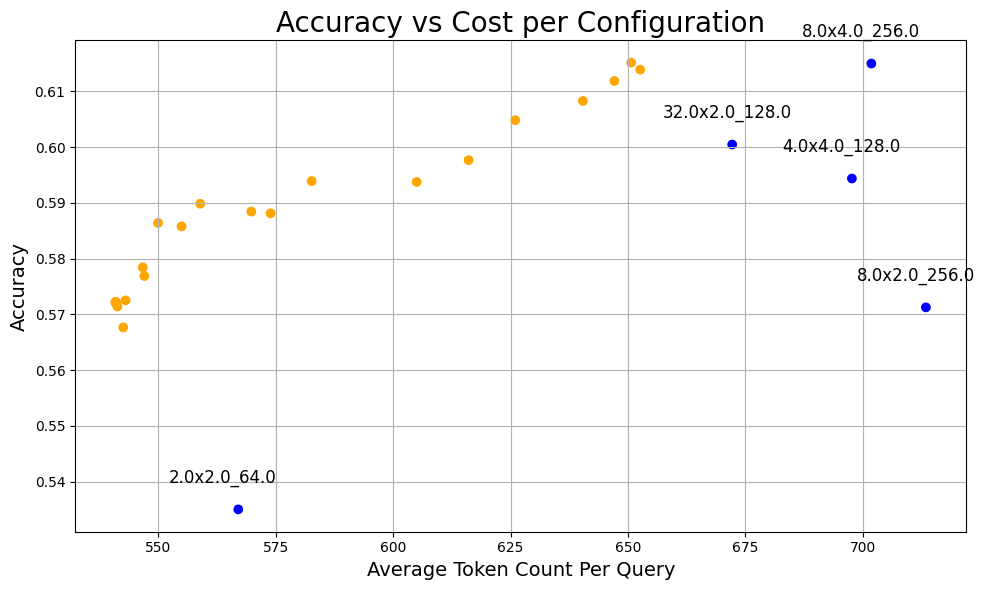

In [ ]:
import matplotlib.pyplot as plt

# Create color labels and text labels
colors = ['orange' if (row['beam_size'], row['beam_width'], row['chunk_size']) == (-1, -1, -1) else 'blue'
          for _, row in query_optimal_static_df.iterrows()]

text_labels = ["qa" if (row['beam_size'], row['beam_width'], row['chunk_size']) == (-1, -1, -1) # f"{round(row['lambda'],5)}"
               else f"{row['beam_size']}x{row['beam_width']}_{row['chunk_size']}"
               for _, row in query_optimal_static_df.iterrows()]

plt.figure(figsize=(10, 6))
plt.scatter(query_optimal_static_df["avg_cot_token_count"], query_optimal_static_df["accuracy"], color=colors)

# Annotate each point
for i, label in enumerate(text_labels):
    if label != "qa":
        plt.annotate(label,
                    (query_optimal_static_df["avg_cot_token_count"][i], query_optimal_static_df["accuracy"][i]),
                    textcoords="offset points", xytext=(-50, 19), ha='left', fontsize=12)
    # else:
    #     plt.annotate(label,
    #                 query_optimal_static_df["lambda"][i],
    #                 textcoords="offset points", xytext=(0, 0), ha='bottom', fontsize=3, color='orange')

plt.xlabel("Average Token Count Per Query", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=20)
plt.grid(True)
plt.tight_layout()

# plt.savefig("figs/accuracy_vs_cost_by_config3", dpi=300, bbox_inches='tight')

### Train XGBoost Classifier

In [95]:
import xgboost as xgb

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

/dccstor/gma2/jhjenny9/envs/model_serve/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:46:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [96]:
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Binary Classification Accuracy: {acc:.4f}")

Binary Classification Accuracy: 0.6980


In [97]:
# compute AUC
# Get predicted probabilities for the positive class (label 1)
y_proba = model.predict_proba(X_test)[:, 1]

# Compute AUC
auc = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc:.4f}")

AUC: 0.7474


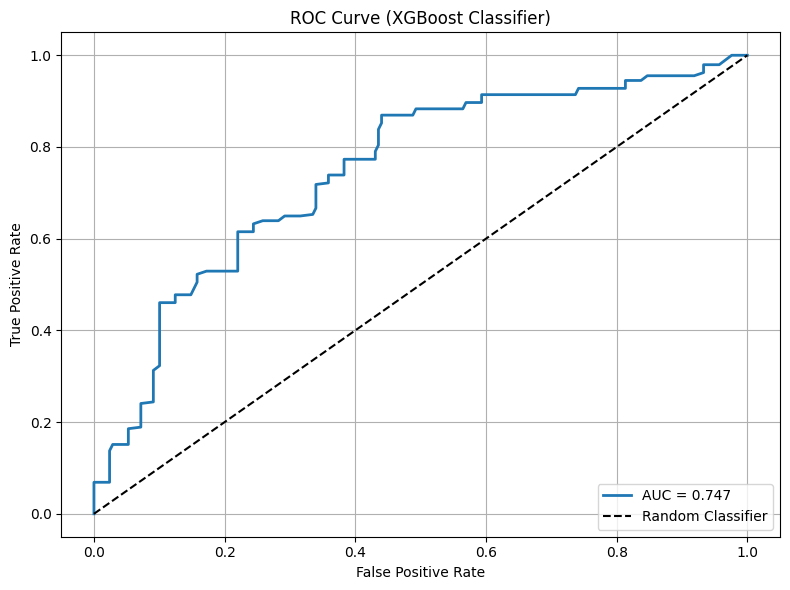

In [98]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (XGBoost Classifier)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
# plt.show()

# plt.savefig("figs/roc_all_xgboost.png")
# plt.savefig("figs/roc_all_xgboost_5configs.png")

In [ ]:
import shap

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test) # SHAP values for each sample

In [ ]:
### get SHAP values for hyperparameter predictors.
beam_size_shap = shap_values.values[:, -6]
beam_width_shap = shap_values.values[:, -5]
chunk_size_shap= shap_values.values[:, -4]
question_length_shap = shap_values.values[:, -2]
num_samples_shap = shap_values.values[:, -1]

# Summary statistics
print(f"Mean SHAP value for 'beam size': {beam_size_shap.mean():.4f}")
print(f"Mean SHAP value for 'beam width': {beam_width_shap.mean():.4f}")
print(f"Mean SHAP value for 'chunk size': {chunk_size_shap.mean():.4f}")
print(f"Mean SHAP value for 'question length': {question_length_shap.mean():.4f}")
print(f"Mean SHAP value for 'num samples': {num_samples_shap.mean():.4f}")

Mean SHAP value for 'beam size': 0.0167
Mean SHAP value for 'beam width': 0.0400
Mean SHAP value for 'chunk size': -0.0248
Mean SHAP value for '50% beam length': 0.0092
Mean SHAP value for 'question length': 0.0634
Mean SHAP value for 'num samples': 0.3573


In [53]:
import numpy as np

shap_array = shap_values.values  # shape: (n_samples, n_features)
# Mean SHAP across first k features for each sample
mean_shap_CLS = shap_array[:, :768].mean(axis=1)

# Optional: get global mean across all samples
global_mean_shap_CLS = mean_shap_CLS.mean()
print(f"Mean SHAP value for CLS feature: {global_mean_shap_CLS:.4f}")

Mean SHAP value for CLS feature: 0.0008
